> **Problem overview**

In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

To learn how to handle large datasets with ease and solve this problem using TensorFlow, consider taking the Machine Learning with TensorFlow on Google Cloud Platform specialization on Coursera -- the taxi fare problem is one of several real-world problems that are used as case studies in the series of courses. To make this easier, head to Coursera.org/NEXTextended to claim this specialization for free for the first month!

In [1]:
# import library
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# import data preprocessing from sklearn
from sklearn.preprocessing import RobustScaler

# import model function from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# import model selection from sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# import model evaluation regression metrics from sklearn
from sklearn.metrics import mean_squared_error

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring training and testing data
train_df = pd.read_csv('../input/train.csv', nrows = 2000000, parse_dates=['pickup_datetime'])
test_df = pd.read_csv('../input/test.csv', parse_dates=['pickup_datetime'])

In [3]:
# visualize head of the training data
train_df.head(n=3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2


In [4]:
# visualize tail of the testing data
test_df.tail(n=3)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19,-73.985573,40.735432,-73.939178,40.801731,6
9913,2015-01-18 14:06:23.0000006,2015-01-18 14:06:23,-73.988022,40.754070,-74.000282,40.759220,6


In [5]:
# convert training dataframe fare amount to log fare amount
train_df['fare_amount'] = train_df['fare_amount'].apply(lambda x: np.log1p(x))

In [6]:
# drop na
train_df = train_df.dropna()

In [7]:
# combine training and testing dataframe
train_df['datatype'], test_df['datatype'] = 'training', 'testing'
test_df.insert(1, 'fare_amount', 0)
data_df = pd.concat([train_df, test_df])
data_df.head(n=3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,datatype
0,2009-06-15 17:26:21.0000001,1.704748,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,training
1,2010-01-05 16:52:16.0000002,2.884801,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,training
2,2011-08-18 00:35:00.00000049,1.902108,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,training


> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [8]:
# describe training and testing data
data_df.describe(include='all')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,datatype
count,2009823,2.009823e+06,2009823,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2009823
unique,2009823,NaN,1639932,NaN,NaN,NaN,NaN,NaN,2
top,2012-08-06 20:15:00.0000006,NaN,2011-12-13 22:00:00,NaN,NaN,NaN,NaN,NaN,training
freq,1,NaN,270,NaN,NaN,NaN,NaN,NaN,1999909
first,NaN,NaN,2009-01-01 00:00:46,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2015-06-30 23:53:49,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.321374e+00,NaN,-7.253045e+01,3.993373e+01,-7.253130e+01,3.993225e+01,1.684059e+00,NaN
std,NaN,5.706400e-01,NaN,1.283655e+01,7.963826e+00,1.274335e+01,1.029841e+01,1.314800e+00,NaN
min,NaN,0.000000e+00,NaN,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00,NaN
25%,NaN,1.945910e+00,NaN,-7.399208e+01,4.073492e+01,-7.399141e+01,4.073400e+01,1.000000e+00,NaN


In [9]:
# find distance bewteen 2 latitude and longitude
def distance(lat1, lon1, lat2, lon2):
    angle = 0.017453292519943295 #math.pi / 180
    x = 0.5 - np.cos((lat2 - lat1) * angle) / 2 + np.cos(lat1 * angle) * np.cos(lat2 * angle) * (1 - np.cos((lon2 - lon1) * angle)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(x))

In [10]:
# feature extraction: combination of keyword date
data_df['year'] = data_df['pickup_datetime'].dt.year
data_df['quarter'] = data_df['pickup_datetime'].dt.quarter
data_df['month'] = data_df['pickup_datetime'].dt.month
data_df['weekofyear'] = data_df['pickup_datetime'].dt.weekofyear
data_df['weekday'] = data_df['pickup_datetime'].dt.weekday
data_df['dayofweek'] = data_df['pickup_datetime'].dt.dayofweek
data_df['hour'] = data_df['pickup_datetime'].dt.hour

In [11]:
# feature extraction: distance
data_df['distance'] = distance(data_df['pickup_latitude'], data_df['pickup_longitude'], \
                               data_df['dropoff_latitude'], data_df['dropoff_longitude'])

In [12]:
# feature extraction: fare amount per mile
data_df['fare_per_mile'] = data_df['fare_amount'] / data_df['distance']
data_df['fare_per_mile'] = data_df['fare_per_mile'].apply(lambda x: 0 if x == float('inf') else x)
data_df['fare_per_mile'] = data_df['fare_per_mile'].fillna(0)

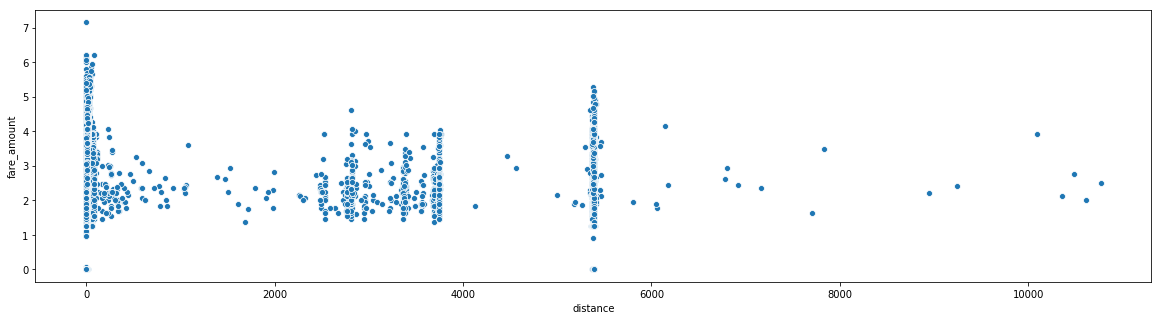

In [13]:
# scatter plot between distance and fare amount
fig, ax = plt.subplots(figsize=(20, 5))
sns.scatterplot(data=data_df[data_df['datatype'] == 'training'], x='distance', y='fare_amount')

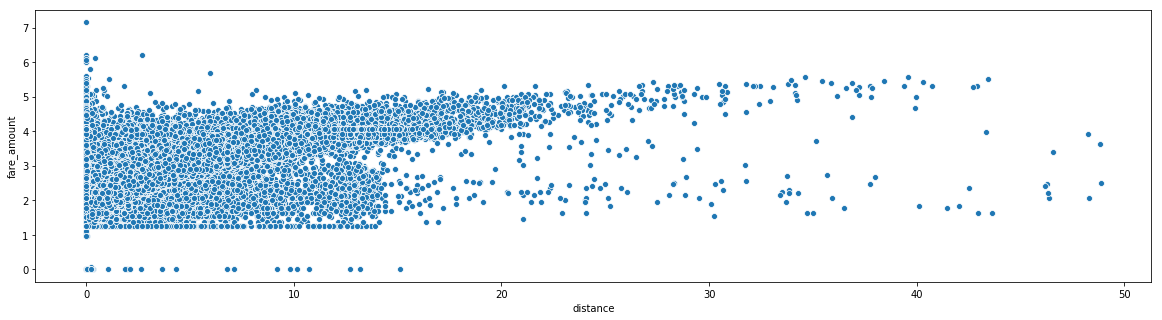

In [14]:
# scatter plot between distance and fare amount
fig, ax = plt.subplots(figsize=(20, 5))
sns.scatterplot(data=data_df[(data_df['datatype'] == 'training') & (data_df['distance'] < 50)], x='distance', y='fare_amount')

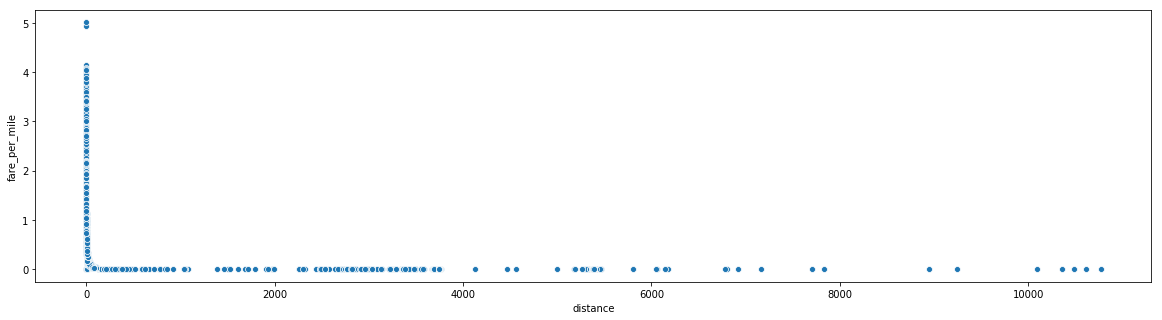

In [15]:
# scatter plot between distance and fare per mile
fig, ax = plt.subplots(figsize=(20, 5))
sns.scatterplot(data=data_df[(data_df['datatype'] == 'training') & (data_df['distance'] > 1)], x='distance', y='fare_per_mile')

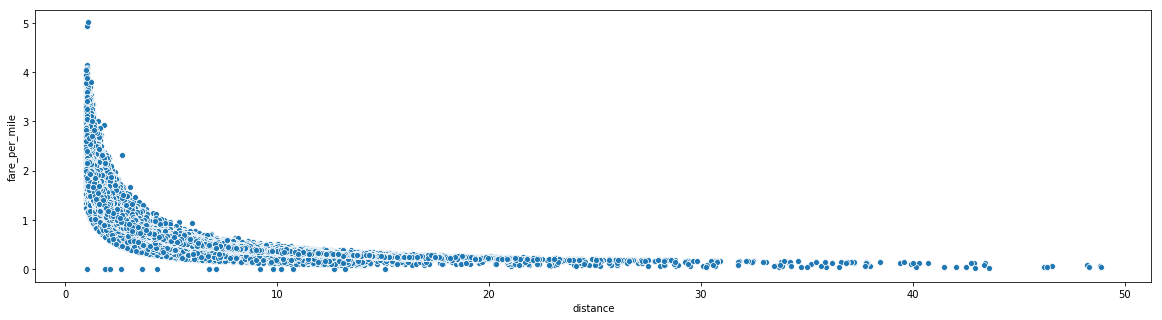

In [16]:
# scatter plot between distance and fare per mile
fig, ax = plt.subplots(figsize=(20, 5))
sns.scatterplot(data=data_df[(data_df['datatype'] == 'training') & (data_df['distance'] > 1) & (data_df['distance'] < 50)], x='distance', y='fare_per_mile')

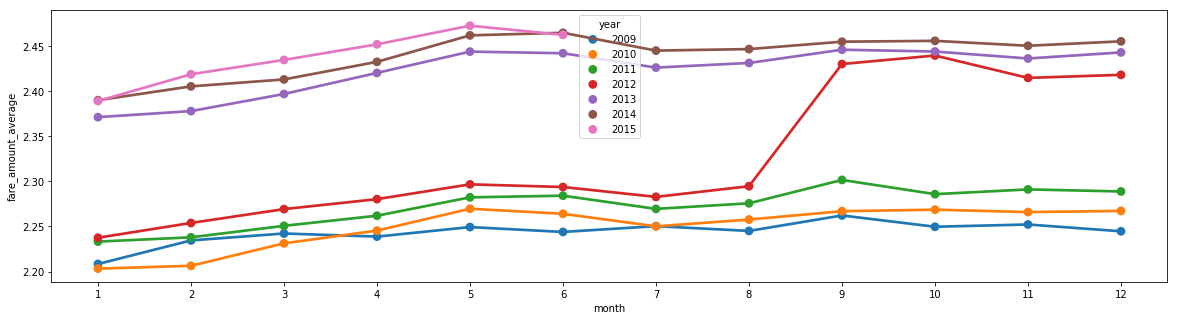

In [17]:
# feature extraction: year-month
groupby = data_df[data_df['datatype'] == 'training'].groupby(['year', 'month'])
groupby = groupby.mean()['fare_amount'].reset_index()
groupby.columns = ['year', 'month', 'fare_amount_average']

fig, ax = plt.subplots(figsize=(20, 5))
pointplot = sns.pointplot(data=groupby, join=True, hue='year', x='month', y='fare_amount_average')

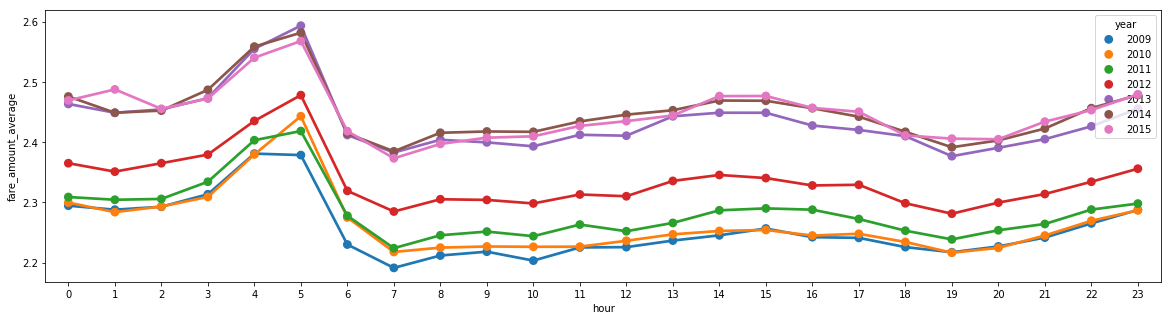

In [18]:
# feature extraction: year-hour
groupby = data_df[data_df['datatype'] == 'training'].groupby(['year', 'hour'])
groupby = groupby.mean()['fare_amount'].reset_index()
groupby.columns = ['year', 'hour', 'fare_amount_average']

fig, ax = plt.subplots(figsize=(20, 5))
pointplot = sns.pointplot(data=groupby, join=True, hue='year', x='hour', y='fare_amount_average')

In [19]:
# feature extraction: datatype
data_df['datatype'] = data_df['datatype'].map({'testing': 0, 'training': 1, 'excluded': '2'})

In [20]:
data_df.head(n=3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,datatype,year,quarter,month,weekofyear,weekday,dayofweek,hour,distance,fare_per_mile
0,2009-06-15 17:26:21.0000001,1.704748,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1,2009,2,6,25,0,0,17,0.640487,2.661643
1,2010-01-05 16:52:16.0000002,2.884801,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,1,2010,1,1,1,1,1,16,5.250670,0.549416
2,2011-08-18 00:35:00.00000049,1.902108,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1,2011,3,8,33,3,3,0,0.863411,2.203015


After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [21]:
# verify dtypes object
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009823 entries, 0 to 9913
Data columns (total 18 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
datatype             object
year                 int64
quarter              int64
month                int64
weekofyear           int64
weekday              int64
dayofweek            int64
hour                 int64
distance             float64
fare_per_mile        float64
dtypes: datetime64[ns](1), float64(7), int64(8), object(2)
memory usage: 291.3+ MB


In [22]:
# convert dtypes object to category
col_obj = data_df.select_dtypes(['object']).columns
data_df[col_obj] = data_df[col_obj].astype('category')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009823 entries, 0 to 9913
Data columns (total 18 columns):
key                  category
fare_amount          float64
pickup_datetime      datetime64[ns]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
datatype             category
year                 int64
quarter              int64
month                int64
weekofyear           int64
weekday              int64
dayofweek            int64
hour                 int64
distance             float64
fare_per_mile        float64
dtypes: category(2), datetime64[ns](1), float64(7), int64(8)
memory usage: 365.6 MB


In [23]:
# convert dtypes category to category codes
col_cat = data_df.select_dtypes(['category']).columns
data_df[col_cat] = data_df[col_cat].apply(lambda x: x.cat.codes)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009823 entries, 0 to 9913
Data columns (total 18 columns):
key                  int32
fare_amount          float64
pickup_datetime      datetime64[ns]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
datatype             int8
year                 int64
quarter              int64
month                int64
weekofyear           int64
weekday              int64
dayofweek            int64
hour                 int64
distance             float64
fare_per_mile        float64
dtypes: datetime64[ns](1), float64(7), int32(1), int64(8), int8(1)
memory usage: 270.3 MB


In [24]:
data_df.head(n=3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,datatype,year,quarter,month,weekofyear,weekday,dayofweek,hour,distance,fare_per_mile
0,140955,1.704748,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1,2009,2,6,25,0,0,17,0.640487,2.661643
1,313147,2.884801,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,1,2010,1,1,1,1,1,16,5.250670,0.549416
2,814497,1.902108,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1,2011,3,8,33,3,3,0,0.863411,2.203015


> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

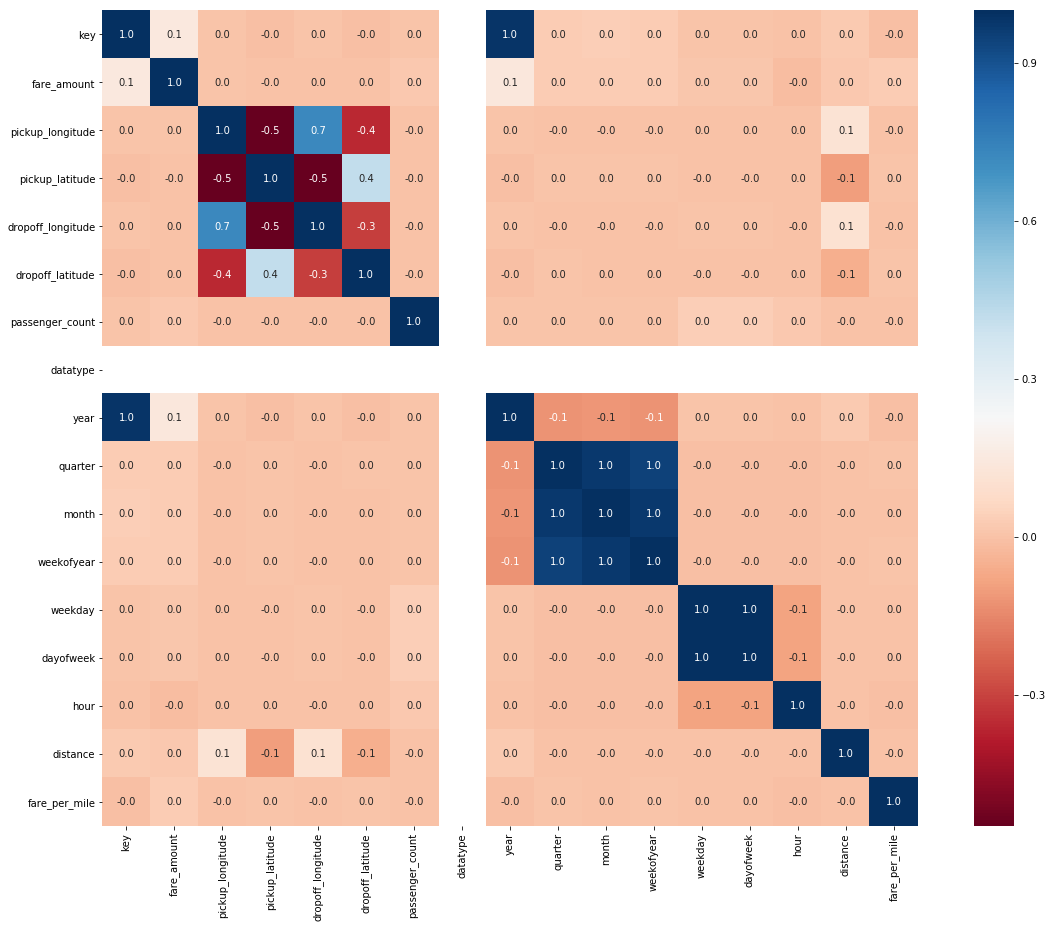

In [25]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = data_df[data_df['datatype'] == 1].corr()
fig, ax = plt.subplots(figsize=(20, 15))
heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True);

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

In [26]:
# plot pairwise relationships in a dataset
#pairplot = sns.pairplot(data_df[data_df['datatype'] == 1], diag_kind='kde', diag_kws=dict(shade=True), hue='fare_amount')

The pivot table and other visulized plots are also another useful methods to observe the impact between features.

In [27]:
# pivot table
pivottable = pd.pivot_table(data_df[data_df['datatype'] == 1], aggfunc=np.mean,
                            columns=['year'], index=['hour'], values='fare_per_mile')
pivottable.style.background_gradient(cmap='Blues')

year,2009,2010,2011,2012,2013,2014,2015
hour,,,,,,,
0,22.0173,13.5861,20.6127,14.5003,21.003,11.3746,11.3583
1,36.774,31.9388,16.5144,18.4534,20.1086,32.2238,10.925
2,31.4023,15.0708,14.7412,9.11018,11.1817,15.0288,5.2437
3,36.5044,30.8214,32.4271,15.0525,15.1137,11.9155,15.2628
4,62.0486,25.5908,26.2653,50.0144,27.7619,53.1213,12.6503
5,106.597,49.5826,37.9778,44.1853,27.6924,41.294,6.57942
6,40.7444,18.5379,18.6242,20.5906,21.2424,34.032,9.90285
7,15.4135,14.3852,15.3536,25.271,14.0432,13.1738,4.28863
8,19.3993,10.0097,17.218,8.98113,8.36387,10.5013,6.34215


> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [28]:
# select all features
x = data_df[data_df['datatype'] == 1].drop(['key', 'pickup_datetime', 'fare_amount', 'datatype', 'fare_per_mile'], axis=1)
y = data_df[data_df['datatype'] == 1]['fare_amount']

In [29]:
x.head(n=3)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,quarter,month,weekofyear,weekday,dayofweek,hour,distance
0,-73.844311,40.721319,-73.841610,40.712278,1,2009,2,6,25,0,0,17,0.640487
1,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,1,1,1,16,5.250670
2,-73.982738,40.761270,-73.991242,40.750562,2,2011,3,8,33,3,3,0,0.863411


In [ ]:
# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

In [ ]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=0, test_size=0.25)

In [ ]:
# model prediction
linreg = LinearRegression().fit(x_train, y_train)
linreg_ypredict = linreg.predict(x_validate)
linreg_mse = mean_squared_error(y_validate, linreg_ypredict) ** 0.5
linreg_cvscores = np.sqrt(np.abs(cross_val_score(linreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('linear regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(linreg_mse, linreg_cvscores.mean(), 2 * linreg_cvscores.std()))

lassoreg = Lasso(alpha=0.1).fit(x_train, y_train)
lassoreg_ypredict = lassoreg.predict(x_validate)
lassoreg_mse = mean_squared_error(y_validate, lassoreg_ypredict) ** 0.5
lassoreg_cvscores = np.sqrt(np.abs(cross_val_score(lassoreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('lasso regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(lassoreg_mse, lassoreg_cvscores.mean(), 2 * lassoreg_cvscores.std()))

ridgereg = Ridge(alpha=10).fit(x_train, y_train)
ridgereg_ypredict = ridgereg.predict(x_validate)
ridgereg_mse = mean_squared_error(y_validate, ridgereg_ypredict) ** 0.5
ridgereg_cvscores = np.sqrt(np.abs(cross_val_score(ridgereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('ridge regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(ridgereg_mse, ridgereg_cvscores.mean(), 2 * ridgereg_cvscores.std()))

In [ ]:
# decision tree model prediction
treereg = DecisionTreeRegressor(max_depth=20, min_samples_split=5, splitter='best').fit(x_train, y_train)
treereg_ypredict = treereg.predict(x_validate)
treereg_mse = mean_squared_error(y_validate, treereg_ypredict) ** 0.5
treereg_cvscores = np.sqrt(np.abs(cross_val_score(treereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('decision tree regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(treereg_mse, treereg_cvscores.mean(), 2 * treereg_cvscores.std()))

In [ ]:
# random forest model prediction
forestreg = RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=10, random_state=0).fit(x_train, y_train)
forestreg_ypredict = forestreg.predict(x_validate)
forestreg_mse = mean_squared_error(y_validate, forestreg_ypredict) ** 0.5
forestreg_cvscores = np.sqrt(np.abs(cross_val_score(forestreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('random forest regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(forestreg_mse, forestreg_cvscores.mean(), 2 * forestreg_cvscores.std()))

> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [ ]:
# model selection
model = forestreg

# prepare testing data and compute the observed value
x_test = data_df[data_df['datatype'] == 0].drop(['key', 'pickup_datetime', 'fare_amount', 'datatype', 'fare_per_mile'], axis=1)
x_test = scaler.transform(x_test)
y_test = pd.DataFrame(np.expm1(model.predict(x_test)), columns=['fare_amount'])

In [ ]:
# summit the results
out = pd.DataFrame({'key': test_df['key'], 'fare_amount': y_test['fare_amount']})
out.to_csv('submission.csv', index=False)